# Simulations from the Ricker Model

This tutorial is about simulation: Simulating your own data with a generative model. This is not only convenient if there is no data available, but also helpful to learn analysing your model in the sense, that you can determine the noise in your data: You know where uncertainties come from and we know the *true* process dynamic.
The model we use is simple population growth model, that is based on the logistic growth equation: The Ricker Model (https://en.wikipedia.org/wiki/Ricker_model).
We thus have a process model with complicated behaviour that I extended to versions from which simulate any kind of data:
- Chaotic or non-chaotic
- single-species or multi-species
- dependent on exogeneous factors (Temperature only) or not
- deterministic or stochastic (that refers to fully observable or with observation error, currently)

You find the code for this project on Github (https://github.com/MWesselkamp/Ricker), relevant for you are currently only the files:
- simulations.py
- models.py (imported by simulations.py)
- utils.py (and this one just because simulations.py needs utils.py)

In [11]:
import simulations
import matplotlib.pyplot as plt
import numpy as np

### The single species Ricker model

Let's start. We want a simulator object, that let's us make choices on the model and then on the way of simulation.

Try out the following code lines below, but also start looking into the source files while you do it.
Try to answer the questions below:
- What makes the difference between non-chaotic and chaotic?
- What happens when you increase the initial size? What when you change ensemble size and what does *ensemble* apparently refer to?
- What are the default parameter values, that we use when simulating with our simulation object *sims*?

**Your answers**


SIMULATION UNDER THE FOLLOWING CONDITIONS:
Type of Ricker Model that will be used:    single-species
Simulation from Ricker in the following regime:   non-chaotic
Exogeneous impact on state variable considered?    exogeneous


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


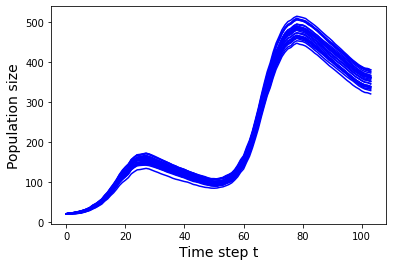

In [12]:
# create simulator object
sims = simulations.Simulator(model_type="single-species",
                             simulation_regime="non-chaotic",
                             environment="exogeneous")
# Set hyperparameters. We'll simulate on a weekly resolution. Years is changed to weeks.
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=30,
                           initial_size=20)
x = sims.simulate() # we don't specify any parameters --> default pars used.
x_base = x.copy() # not required usually

In [13]:
print(x.shape)

(30, 104)


/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


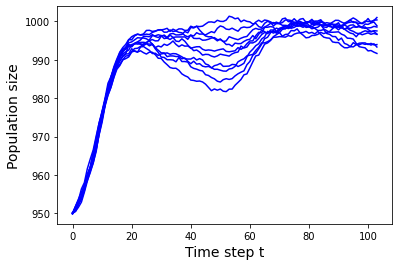

In [14]:
# play around the hyperparameters and see how the simulations varies.
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=10,
                           initial_size=(950))
x_true = sims.simulate() # still using default model parameters

Now let's change the simulation parameters: These are the actual model parameters!
They determine the dynamics of the population growth process, we well as the errors that we consider in the simulation.

- What did we change here, compared to the default parameter values?

/Users/Marieke_Wesselkamp/PycharmProjects/Ricker/models.py:153: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


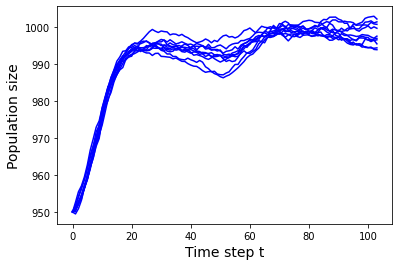

In [15]:
sims.hyper_parameters(simulated_years=2,
                           ensemble_size=10,
                           initial_size=(950))
x_true = sims.simulate(pars={'theta': None,'sigma': 0.01,'phi': 0.5,'initial_uncertainty': 1e-1})

## Density estimation and cumulative probability

Some data will not fit nicely in any known probability distribution. Sometime, however, we need a probability density function for our data - for example if we want to compute a measure of predictability based on the climatological distribution. In a perfect model scenario, that is the distribution at a current time $t$, simulated from the model that has been initialized in an approx. infinite past $t-n$ with all uncertainties **fully** propagated up to $t$.
This is obviously not the case here, but considering we're in a perfect model framework, through many simulations we propagate the uncertainty:
- initial condition uncertainty through simulating ensembles
- model uncertainty through observation error
- exogenous variable uncertainty we currently neglect.
- parameter uncertainty we currently neglect.
We plot the whole simulated data set and see, that this might be an unknown distribution

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_35835/3182759623.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


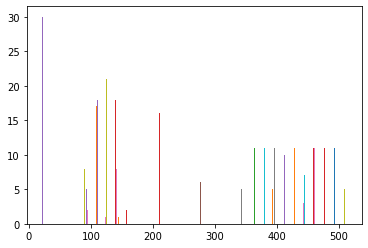

In [16]:
fig = plt.figure()
ax = fig.add_subplot()
plt.hist(x, bins=30)
fig.show()

In [17]:
# Just this histogram is not very helpful: It shows the total height at each location, but it would be nice to have it smooth. This is what Kernel density estimation is used for (https://scikit-learn.org/stable/modules/density.html).
from sklearn.neighbors import KernelDensity

x_values = np.linspace(0,100, 100)[:, np.newaxis]
x_new = np.concatenate(x)[:, np.newaxis]
kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(x_new) # the higher the bandwidth the smoother
log_dens = kde.score_samples(x_values)


An empirical cumulative distributions functions orders the values and assigns probabilities. It's usually estimated with some kernel density estimator. In python, we can fit the function ecdf in the statsmodel package to get the ecdf of our data. It displays the probability that a random variable $X$ will take a values less or equal to x.
$F_X(x) = P(X \leq x)$.

/var/folders/s8/rp7pfvm507qcvckzx566r47c0000gp/T/ipykernel_35835/1077951179.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


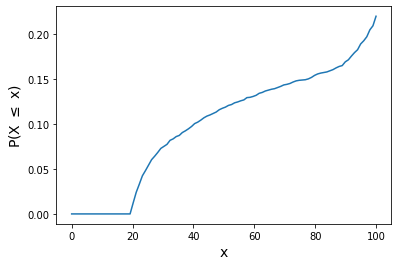

In [18]:
from statsmodels.distributions.empirical_distribution import ECDF

ecdf = ECDF(x.flatten())
x_probs = ecdf(x_values)

fig = plt.figure()
ax = fig.add_subplot()
plt.plot(x_values, x_probs)
#plt.plot(ecdf.x, ecdf.y)
ax.set_xlabel('x', size=14)
ax.set_ylabel('P(X $\leq$ x)', size=14)
fig.show()
#ecdf.y

# Structured sampling

## Group-specific parameters with homogeneous process error.

In [19]:
# Let's do the same simulation but with structured sampling: We sample multiple populations with slightly different true parameter values.


## Group-specific parameters with heterogeneous process error.

# Splitting the data

In machine learning it's common to split the data into three chunks: A training set, a validation set and a test set. We can summarize the training and validation set, as we will pursue the training procedure in a cross-validation anyways. This is done to prevent overfitting. The test set will be held out and used for validation only.
Equivalently for forecasting: We have a long series of historical data, that our model and parameters are based on. For the time period we want to forecast, there are no observations available in the real world. In the simulation setting, however, we can of course evaluate the forecast.
As such, this section will be dedicated to data splitting for both use cases.

## Splitting data for forecasting with the Ricker

In the perfect model framework, we assume
- no parameter uncertainty
- no model structural uncertainty
- a fully known analyses distribution

Cut the simulation off to a random time step $t=180$, from which on, we assume no observations available anymore.
We don't have to care about the parameters. We have a distribution at this point of **all X** , as well as of the last days only.



In [20]:
def split_data(x, t = 180):
    x_train, x_test = x[:,:t], x[:,t:]
    return x_train, x_test

# Using scipy integration.

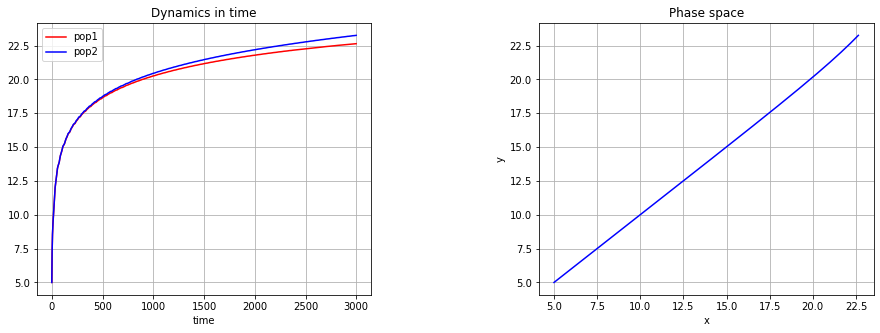

In [21]:
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
import utils


def lambda_x(t):
    ind = int(t)
    return 0.7 + 0.03 * T[ind] + 0.1 * T[ind]**2

def lambda_y(t):
    ind = int(t)
    return 0.7 + 0.03 * T[ind] + 0.1 * T[ind]**2

def sys(X, t, lambda_x, lambda_y):

    #define system as array

    Nx =  X[0] * np.exp(lambda_x(t)*(1- 1/20*X[0] - 0.60002*X[1]))
    Ny = X[1] * np.exp(lambda_y(t)*(1 - 1/20*X[1] - 0.60001*X[0]))

    return np.array([Nx, Ny])

timesteps = 3000
t = np.linspace(1,timesteps, timesteps)
T = utils.simulate_T(timesteps*5,show=False)
X_in = [5, 5]

args = (lambda_x, lambda_y)
X, infodict = integrate.odeint(sys, X_in, t, args, full_output=True)

x,y = X.T

#plot
fig = plt.figure(figsize=(15,5))
fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.plot(x, 'r-', label='pop1')
ax1.plot(y, 'b-', label='pop2')
ax1.set_title("Dynamics in time")
ax1.set_xlabel("time")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(x, y, color="blue")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Phase space")
ax2.grid()